## Colab을 위한 작업
---

### 추가 라이브러리 설치 및 업데이트

In [ ]:
!pip install --upgrade music21
!pip install tensorflow
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### GPU 정보 확인

In [ ]:
!nvidia-smi
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Tue Oct 18 06:36:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    29W /  70W |   2872MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 라이브러리

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os                                                     # 윈도우 명령어
import time                                                   # 시간 관련

import glob                                                   # 파일 경로
import pickle

from music21 import *                                         # 음성처리 MIT-Music21

#Run version 2.9.0
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split # train, test 데이터 분리

### 드라이브 연결 및 작업 위치 변경

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content')
os.chdir('drive/MyDrive/Work/BiLSTM-music/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 생성하기
---

## 함수 정의
----

In [ ]:
def div_chord(c):
   new_notes = []
   
   for e in c.pitches:                                 #  코드(chord)를 음표(note)로 변환
      new_note = note.Note(e)                          #  pitch를 음표로 변환
      new_note.quarterLength = c.quarterLength         #  음표 길이
      new_note.offset = c.offset                       #  악보 처음부터 음표까지의 Offset
      new_notes.append(new_note)                       #  배열에 추가
   
   return new_notes

In [ ]:
def div_by_clef(notes):
   tc_notes = [] # Treble Clef Notes                   # 높은 음자리표 추출 음표
   bc_notes = [] # Bass Clef Notes                     # 낮은 음자리표 추출 음표

   for e in notes:
      if isinstance(e, chord.Chord):
         e = div_chord(e)
         a, b = div_by_clef(e)
         tc_notes.extend(a)                            # EXTEND는 LIST 추가 가능함.
         bc_notes.extend(b)
      elif isinstance(e, note.Note):
         if isinstance(clef.bestClef(stream.Stream([e])), clef.TrebleClef):
            tc_notes.append(e)
         else:
            bc_notes.append(e)

   return tc_notes, bc_notes

In [ ]:
def find_rest(prev_note, next_note):
   new_rest = note.Rest()                              # 쉼표 생성
   new_rest.offset        = prev_note.offset + prev_note.quarterLength
   new_rest.quarterLength = next_note.offset - new_rest.offset
   return new_rest

In [ ]:
def resort_notes(notes):
   new_notes = [notes[0]]
   for e in notes[1:]:
      n = new_notes.pop()                  # e가 n의 다음 음표
      ql = e.offset - n.offset

      if ql == 0:                          # 어떤음의 offset의 차이가 0이라는 것은 Chord를 의미함.
         new_chord = chord.Chord([n, e])
         new_chord.quarterLength = n.quarterLength
         new_chord.offset = n.offset
         new_notes.append(new_chord)
      elif ql > 0:
         r = find_rest(n, e)
         if r.quarterLength > 0.0:
            n.quarterLength = r.offset - n.offset
            new_notes.append(n)
            new_notes.append(r)
         else:
            n.quarterLength = ql
            new_notes.append(n)
         new_notes.append(e)
      else:
         raise Exception(f"Current-offset({n.offset}) is Larger than Next-offset({e.offset}).")
   
   return new_notes

In [ ]:
def add_notes_to_offset(notes, offset=0.0):
   new_notes = []
   
   for e in notes:
      e.offset += offset
      new_notes.append(e)
   
   return new_notes

In [ ]:
def get_notes():
   notes = []
   offset = 0.0
   
   for file in sorted(glob.glob('midi_songs/*.mid')):
      org_s = converter.parse(file)
      pbi_s = instrument.partitionByInstrument(org_s)
      rec_s = pbi_s.recurse()                 # music21.stream.iterator.RecursiveIterator
      ns = rec_s.notes

      ns = add_notes_to_offset(ns, offset)
      notes.extend(ns)

      while offset <= notes[-1].offset:
         offset += 4
   
   return notes

In [ ]:
def zero_rest(offset=0.0):           # 길이가 0인 쉼표
   r = note.Rest()
   r.quarterLength = 0.0
   r.offset = offset
   return r

In [ ]:
def notes_equally(ns1, ns2):
   new_ns1 = []                 # ns = notes, ns1=높은 음자리 표의 음들 ,ns2=낮은 음자리 표의 음들
   new_ns2 = []

   if len(ns1) < len(ns2):
      ns1, ns2 = ns2, ns1
   
   i = 0
   j = 0
   while i < len(ns1):
      if j < len(ns2):
         if ns1[i].offset < ns2[j].offset:
            new_ns1.append(ns1[i])
            new_ns2.append(zero_rest(ns1[i].offset))
            i += 1
         elif ns1[i].offset > ns2[j].offset:
            new_ns1.append(zero_rest(ns2[j].offset))
            new_ns2.append(ns2[j])
            j += 1
         else:
            new_ns1.append(ns1[i])
            new_ns2.append(ns2[j])
            i += 1
            j += 1
      else:
         new_ns1.append(ns1[i])
         new_ns2.append(zero_rest(ns1[i].offset))
         i += 1
   
   return new_ns1, new_ns2

## 실행
----

### 음표 추출

In [ ]:
notes = get_notes()
len(notes) # 음표 개수 출력

42581

### 높은 음자리와 낮은 음자리 나누기

In [ ]:
# 음표를 나누지 않음
# tc_notes, bc_notes = div_by_clef(notes)
# len(tc_notes), len(bc_notes) # 각 음표 개수 출력

### 음표 재나열

In [ ]:
notes = resort_notes(notes)

### 음자리별 음표 개수 맞추기

In [ ]:
# 음표를 나누지 않았으므로 생략
# tc_notes, bc_notes = notes_equally(tc_notes, bc_notes)
# len(tc_notes), len(bc_notes) # 각 음표 개수 출력

### 데이터 저장

In [ ]:
with open('data/niko/notes_mini', 'wb') as f:
  pickle.dump(notes, f)

# 데이터 학습하기
---

## 함수 정의
---

In [ ]:
def note_to_str(e):                            # e : element
   if isinstance(e, note.Note):
      return f'{e.pitch}:{e.quarterLength}'
   elif isinstance(e, chord.Chord):
      return f'{" ".join(str(e) for e in e.pitches)}:{e.quarterLength}'
   else:
      return f'{e.name}:{e.quarterLength}'

In [ ]:
def notes_to_nums(notes):
   str_notes = []
   for e in notes:
      e = note_to_str(e)
      str_notes.append(e)
   
   note_to_int = dict((k, v) for v, k in enumerate(sorted(set(str_notes))))

   num_notes = []
   for e in str_notes:
      e = note_to_int[e]
      num_notes.append(e)

   return num_notes

### prepare sequences

In [ ]:
def prepare_sequences(nums, sl=4):  # nums=num_notes , sl=sequence length
   x = []
   y = []

   for i in range(len(nums) - sl):
      x.append(nums[i:sl+i])
      y.append(nums[i+sl])
   
   x = np.array(x)
   y = np_utils.to_categorical(y)

   return x, y

### create model

In [ ]:
def createModel(x, y):
  vocab = y.shape[1]                        # 출력의 클래스 개수

  # inputs
  input = Input(x.shape[1], name="Input")   # x.shape[1] = sequence length

  # channel 1
  z = Embedding(vocab, 4, name="Embedding")(input) # 4 : Embedding 차원
  z = LSTM(64, return_sequences=True, name="LSTM")(z)
  # z = Bidirectional(LSTM(64, return_sequences=True), name="Bi-LSTM")(z)
  # z = SeqSelfAttention(attention_activation='sigmoid', name="Attention")(z)
  z = Dropout(0.25, name="Dropout")(z)
  z = Flatten(name="Flatten_Layer")(z)

  # output
  output = Dense(vocab, activation='softmax', name="Output")(z)

  model = Model(inputs=input, outputs=output, name="LSTM_Model")
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
  return model

## 실행
---

### 데이터 불러오기

In [ ]:
with open('data/niko/notes_mini', 'rb') as f:
  notes = pickle.load(f)

### 음표를 숫자로 바꾸기

In [ ]:
nums = notes_to_nums(notes)
nums[:10]

[325, 1908, 1985, 5178, 1962, 1992, 5178, 1962, 1992, 5178]

### 모델 입출력 데이터 만들기

In [ ]:
x, y = prepare_sequences(nums, 8)
x.shape, y.shape # shape 출력

((42573, 8), (42573, 5200))

### 모델 생성하기

In [ ]:
model = createModel(x, y)
model.summary()

Model: "Bi-LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8)]               0         
                                                                 
 Embedding (Embedding)       (None, 8, 4)              20800     
                                                                 
 LSTM (LSTM)                 (None, 8, 64)             17664     
                                                                 
 Dropout (Dropout)           (None, 8, 64)             0         
                                                                 
 Flaten_Layer (Flatten)      (None, 512)               0         
                                                                 
 Output (Dense)              (None, 5200)              2667600   
                                                                 
Total params: 2,706,064
Trainable params: 2,706,064
N

### 모델 이미지 출력

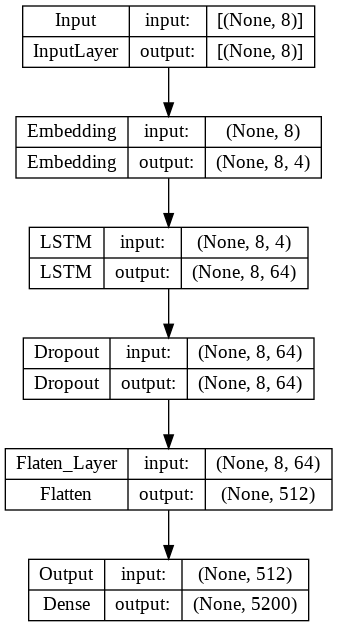

In [ ]:
plot_model(model, to_file='Model(LSTM)_mini.png', show_shapes=True)

### 모델 학습하기

In [ ]:
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
        filepath,
        period=20, #Every 20 epochs
        monitor="acc",
        verbose=1,
        save_best_only=False,
        mode='min'
    )
callbacks_list = [checkpoint]

history = model.fit(
    x=x,
    y=y, 
    validation_data=(x[::5], y[::5]), 
    epochs=200,
    batch_size=128,
    callbacks=callbacks_list)

Epoch 1/200
333/333 [==============================] - 5s 11ms/step - loss: 6.4820 - accuracy: 0.0385 - val_loss: 6.0549 - val_accuracy: 0.0419
Epoch 2/200
333/333 [==============================] - 3s 8ms/step - loss: 6.0761 - accuracy: 0.0392 - val_loss: 5.9902 - val_accuracy: 0.0420
Epoch 3/200
333/333 [==============================] - 3s 8ms/step - loss: 5.9391 - accuracy: 0.0479 - val_loss: 5.7253 - val_accuracy: 0.0611
Epoch 4/200
333/333 [==============================] - 3s 8ms/step - loss: 5.7302 - accuracy: 0.0607 - val_loss: 5.5663 - val_accuracy: 0.0655
Epoch 5/200
333/333 [==============================] - 3s 8ms/step - loss: 5.5945 - accuracy: 0.0628 - val_loss: 5.4327 - val_accuracy: 0.0688
Epoch 6/200
333/333 [==============================] - 3s 8ms/step - loss: 5.4792 - accuracy: 0.0682 - val_loss: 5.3102 - val_accuracy: 0.0733
Epoch 7/200
333/333 [==============================] - 3s 8ms/step - loss: 5.3656 - accuracy: 0.0716 - val_loss: 5.1950 - val_accuracy: 0.076

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### 모델 학습 결과 그래프

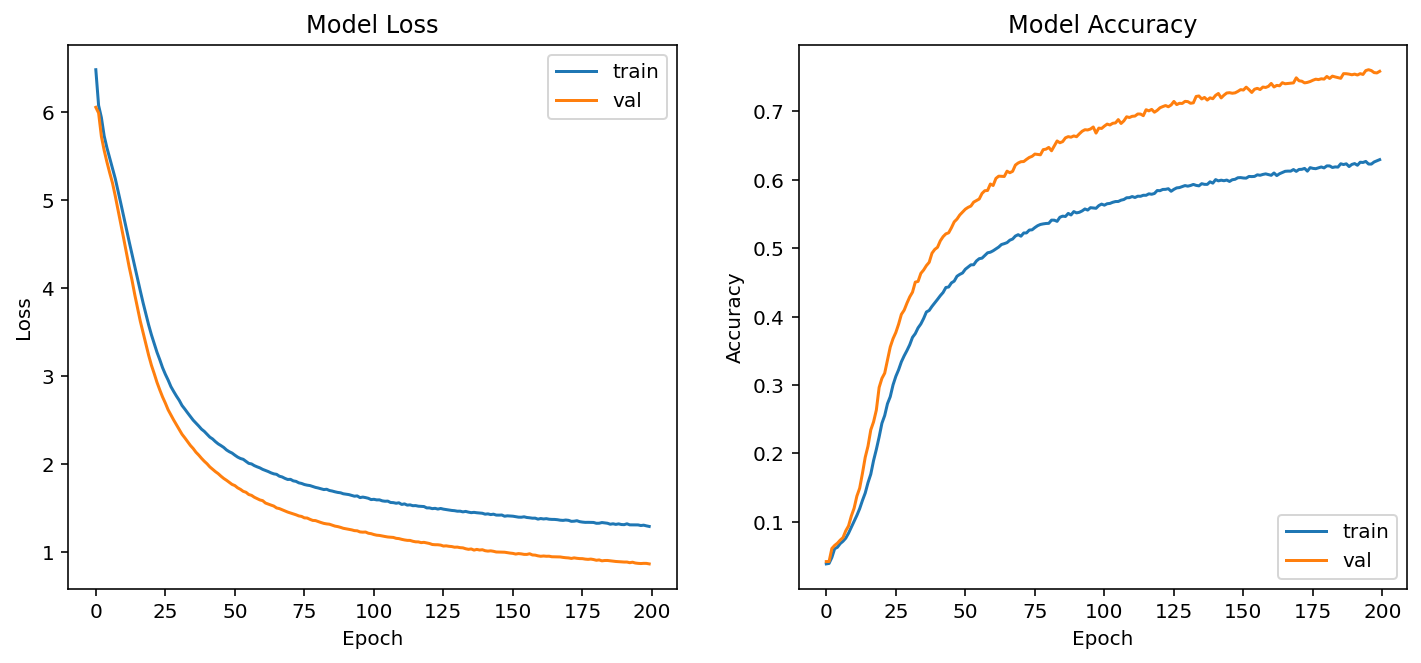

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.savefig('Loss and Accuarcy(LSTM)_mini.png', dpi=300)
plt.show()

### 모델 학습 결과 정확도

In [ ]:
for epoch in range(20, 201, 20):
  epoch -= 1
  print('epoch {} 정확도: {:.2f}%'.format(epoch+1, history.history['accuracy'][epoch]*100))

epoch 20 정확도: 22.40%
epoch 40 정확도: 42.00%
epoch 60 정확도: 49.42%
epoch 80 정확도: 53.61%
epoch 100 정확도: 56.44%
epoch 120 정확도: 58.43%
epoch 140 정확도: 59.51%
epoch 160 정확도: 60.75%
epoch 180 정확도: 61.73%
epoch 200 정확도: 62.94%


# 결과물(MIDI파일) 생성하기
---

## 함수정의

In [ ]:
def convert_to_float(frac_str):   # quarterLength에 슬래시(/)가 있는 float으로 처리하는 과정.
   try:
      return float(frac_str)
   except ValueError:
      num, denom = frac_str.split('/')
      try:
         leading, num = num.split(' ')
         whole = float(leading)
      except ValueError:
         whole = 0
      frac = float(num) / float(denom)
      return whole - frac if whole < 0 else whole + frac

### str to note

In [ ]:
def str_to_note(s):                   #note to strign --> note
  temp = s.split(':')
  n = temp[0]
  q = convert_to_float(temp[1])

  if ' ' in n:
    new_chord = chord.Chord(n)
    new_chord.quarterLength = q
    return new_chord
  elif 'rest' in n:
    new_rest = note.Rest(n)
    new_rest.quarterLength = q
    return new_rest
  else:
    new_note = note.Note(n)
    new_note.quarterLength = q
    return new_note

In [ ]:
def nums_to_notes(nums, notes):    # 숫자들로 이루어진 값을 note로 변환
   str_notes = []
   for e in notes:
      e = note_to_str(e)
      str_notes.append(e)
   
   int_to_str = dict((k, v) for k, v in enumerate(sorted(set(str_notes))))

   offset = 0.0
   new_notes = []
   for n in nums:
      e = str_to_note(int_to_str[n])
      if e.quarterLength > 0.0:
         e.offset = offset
         new_notes.append(e)
         offset += e.quarterLength

   return new_notes

### generate_notes(model, tc_nums, bc_nums, size)

In [ ]:
def generate_notes(model, nums, size):
  new_nums = []
  sl = model.inputs[0].shape[1]
  r_max = len(nums) - sl
  r = np.random.randint(0, r_max)

  nums = nums[r:r+sl]
  for i in range(size):
    x = np.reshape(nums, (1, sl))

    y = model.predict(x, verbose=0)
    n = np.argmax(y)

    new_nums.append(n)

    nums.append(n)
    nums = nums[1:sl+1]
  
  return new_nums


In [ ]:
def create_midi(notes, fp="output/temp.mid", show_txt=False):
   part1 = stream.Part(notes)

   new_stream = stream.Stream(part1)
   if show_txt:
      new_stream.show('txt')
   new_stream.write('midi', fp)

## 실행
---

### 데이터 불러오기

In [ ]:
with open('data/niko/notes_mini', 'rb') as f:   # 윗쪽에 있는 데이터 생성하기에서 만들어진 데이터를 가져옴
  notes = pickle.load(f)

### 음표를 숫자로 바꾸기

In [ ]:
nums = notes_to_nums(notes)
nums[:10]

[325, 1908, 1985, 5178, 1962, 1992, 5178, 1962, 1992, 5178]

### 모델 입출력 데이터 만들기

In [ ]:
x, y = prepare_sequences(nums, 8)
x.shape, y.shape # shape 출력

((42573, 8), (42573, 5200))

### 모델 생성 및 가중치 적용하기

In [ ]:
model = createModel(x, y)
model.load_weights('weights-improvement-200-0.7158-bigger.hdf5')

### 숫자 데이터 생성하기

In [ ]:
new_nums = generate_notes(model, nums, 500)
len(new_nums)

500

### 숫자로 된 데이터를 음표로 바꾸기

In [ ]:
new_notes = nums_to_notes(new_nums, notes)
len(new_notes)

500

### 음자리별 음표 개수 맞추기

In [ ]:
# 생략
# new_tc, new_bc = notes_equally(new_tc, new_bc)
# len(new_tc), len(new_bc)

### MIDI 파일 생성하기

In [ ]:
t = time.strftime("%y%m%d%H%M%S", time.localtime(time.time()))
create_midi(new_notes, fp=f"output/niko/output-1LSTM-200_{t}.mid", show_txt=True)

{0.0} <music21.stream.Part 0x7f70696f6090>
    {0.0} <music21.note.Note C>
    {0.6667} <music21.chord.Chord B3 C5>
    {1.3333} <music21.note.Note C>
    {2.3333} <music21.note.Note B>
    {2.8333} <music21.note.Note C>
    {3.5} <music21.note.Note B>
    {3.75} <music21.note.Note A>
    {4.25} <music21.note.Note C>
    {4.75} <music21.note.Note F>
    {5.75} <music21.note.Note A>
    {6.4167} <music21.chord.Chord C3 C5>
    {6.9167} <music21.note.Note F>
    {7.1667} <music21.note.Note A>
    {7.6667} <music21.chord.Chord A3 C5>
    {8.3333} <music21.chord.Chord C4 G5>
    {8.8333} <music21.note.Note C>
    {9.5833} <music21.note.Note A>
    {9.8333} <music21.note.Note F>
    {10.3333} <music21.note.Note C>
    {10.8333} <music21.note.Note C>
    {11.8333} <music21.note.Note E>
    {12.3333} <music21.chord.Chord G2 C5>
    {13.0} <music21.note.Note C>
    {13.25} <music21.note.Note E>
    {13.75} <music21.chord.Chord E3 C5>
    {14.25} <music21.note.Note G>
    {14.9167} <music21.not

### MIDI 파일 반복 생성

In [ ]:
# 데이터 불러오기
with open('data/niko/notes_mini', 'rb') as f:
  notes = pickle.load(f)

# 음표를 숫자로 바꾸기
nums = notes_to_nums(notes)

# 모델 입출력 데이터 만들기
x, y = prepare_sequences(nums, 8)

for epoch in range(180, 201, 20):
  # 가중치 파일
  weights_file = glob.glob(f"weights-improvement-{epoch}-*-bigger.hdf5")[0]

  # 모델 생성 및 가중치 적용하기
  model = createModel(x, y)
  model.load_weights(weights_file)

  for i in range(10):
    # 숫자 데이터 생성하기
    new_nums = generate_notes(model, nums, 500)
    # 숫자로 된 데이터를 음표로 바꾸기
    new_notes = nums_to_notes(new_nums, notes)
    # MIDI파일 생성하기
    t = time.strftime("%y%m%d%H%M%S", time.localtime(time.time()))
    create_midi(new_notes, fp=f"output/output-LSTM-{epoch}_{t}.mid", show_txt=False)